# 基于二维谱神经算子的纳维斯托克斯方程求解

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/zh_cn/data_driven/mindspore_navier_stokes_SNO2D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/zh_cn/data_driven/mindspore_navier_stokes_SNO2D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/data_driven/navier_stokes_SNO2D.ipynb)

## 概述

计算流体力学是21世纪流体力学领域的重要技术之一，其通过使用数值方法在计算机中对流体力学的控制方程进行求解，从而实现流动的分析、预测和控制。传统的有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM）常用于复杂的仿真流程（物理建模、网格划分、数值离散、迭代求解等）和较高的计算成本，往往效率低下。因此，借助AI提升流体仿真效率是十分必要的。

近年来，随着神经网络的迅猛发展，为科学计算提供了新的范式。经典的神经网络是在有限维度的空间进行映射，只能学习与特定离散化相关的解。与经典神经网络不同，傅里叶神经算子（Fourier Neural Operator，FNO）是一种能够学习无限维函数空间映射的新型深度学习架构。该架构可直接学习从任意函数参数到解的映射，用于解决一类偏微分方程的求解问题，具有更强的泛化能力。更多信息可参考[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895)。

谱神经算子（Spectral Neural Operator，SNO）是利用多项式将计算变换到频谱空间（Chebyshev,Legendre等）的类似FNO的架构。与FNO相比, SNO的特点是由混淆误差引起的系统偏差较小。其中最重要的好处之一是SNO的基的选择更为宽泛，因此可以在其中找到一组最方便表示的多项式。例如，针对问题的对称性或针对时间间隔来选取适应的基。此外，当输入定义在在非结构化网格上时，基于正交多项式的神经算子相比其他谱算子或更有竞争力。

更多信息可参考, "[Spectral Neural Operators](https://arxiv.org/abs/2205.10573)". arXiv preprint arXiv:2205.10573 (2022).

本案例教程介绍了利用频谱神经算子求解Navier-Stokes方程的方法。

## 纳维-斯托克斯方程（Navier-Stokes equation）

纳维-斯托克斯方程（Navier-Stokes equation）是计算流体力学领域的经典方程，是一组描述流体动量守恒的偏微分方程，简称N-S方程。它在二维不可压缩流动中的涡量形式如下：

$$
\partial_t w(x, t)+u(x, t) \cdot \nabla w(x, t)=\nu \Delta w(x, t)+f(x), \quad x \in(0,1)^2, t \in(0, T]
$$

$$
\nabla \cdot u(x, t)=0, \quad x \in(0,1)^2, t \in[0, T]
$$

$$
w(x, 0)=w_0(x), \quad x \in(0,1)^2
$$

其中$u$表示速度场，$w=\nabla \times u$表示涡量，$w_0(x)$表示初始条件，$\nu$表示粘度系数，$f(x)$为外力合力项。

## 问题描述

本案例利用Spectral Neural Operator学习某一个时刻对应涡量到下一时刻涡量的映射，实现二维不可压缩N-S方程的求解：

$$
w_t \mapsto w(\cdot, t+1)
$$

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器与损失函数。
4. 模型训练。

## Spectral Neural Operator

### U-SNO修改

下图显示了谱神经算子的架构，它由编码器、多层谱卷积层（谱空间的线性变换）和解码器组成。要计算频谱卷积的正向和逆多项式变换矩阵，应在相应的Gauss正交节点（Chebyshev网格等）对输入进行插值。通过卷积编码层将插值后的输入提升到更高维度的通道。其结果将经过多层谱卷积层，每个层对其截断的谱表示应用线性卷积。SNO层的输出通过卷积解码器投影回目标维度，最后插值回原始节点。

SNO层执行以下操作：将多项式变换$A$应用于光谱空间（Chebyshev，Legendre等）操作；多项式低阶模态上的线性卷积$L$操作，高阶模态上的过滤操作；而后，应用逆变换 $S={A}^{-1}$（回到物理空间）。然后添加输入层的线性卷积 $W$操作，并应用非线性激活层。

U-SNO是基于SNO的强化修改，其中，一系列修改过的SNO卷积层被布置在主序列之后。在修改后的U-SNO层中，$U-Net$体系结构（具有自定义的步骤数）被用作跳过块来代替线性的$W$。

![SNO网络结构](images/USNO.png)

In [1]:
import os
import time
import numpy as np

import mindspore
from mindspore import nn, context, ops, Tensor, jit, set_seed, save_checkpoint
import mindspore.common.dtype as mstype

下述`src`包可以在[applications/data_driven/navier_stokes/sno2d/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/data_driven/navier_stokes/sno2d/src)下载。

In [2]:
from mindflow.cell import SNO2D, get_poly_transform
from mindflow.utils import load_yaml_config, print_log
from mindflow.pde import UnsteadyFlowWithLoss
from src import create_training_dataset, load_interp_data, calculate_l2_error
from mindflow.loss import RelativeRMSELoss
from mindflow.common import get_warmup_cosine_annealing_lr

set_seed(0)
np.random.seed(0)

In [3]:
context.set_context(mode=context.GRAPH_MODE, device_target='GPU', device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
config = load_yaml_config('./configs/sno2d.yaml')

data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]
summary_params = config["summary"]

## 创建数据集

训练与测试数据下载: [data_driven/navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/navier_stokes/dataset/) .

本案例根据Zongyi Li在 [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) 一文中对数据集的设置生成训练数据集与测试数据集。具体设置如下：

基于周期性边界，生成满足如下分布的初始条件$w_0(x)$：

$$
w_0 \sim \mu, \mu=\mathcal{N}\left(0,7^{3 / 2}(-\Delta+49 I)^{-2.5}\right)
$$

外力项设置为：

$$
f(x)=0.1\left(\sin \left(2 \pi\left(x_1+x_2\right)\right)+\right.\cos(2 \pi(x_1+x_2)))
$$

采用Crank-Nicolson方法生成数据，时间步长设置为1e-4，最终数据以每 t = 1 个时间单位记录解。所有数据均在256×256的网格上生成，并被下采样至64×64网格。本案例选取粘度系数$\nu=1e−5$，训练集样本量为19000个，测试集样本量为3800个。

In [4]:
poly_type = data_params['poly_type']
load_interp_data(data_params, dataset_type='train')
train_dataset = create_training_dataset(data_params, shuffle=True)

test_data = load_interp_data(data_params, dataset_type='test')
test_input = test_data['test_inputs']
test_label = test_data['test_labels']

batch_size = data_params['batch_size']
resolution = data_params['resolution']

## 构建模型

网络由1个Encoding layer、多个Spectral layer和Decoding block组成:

- 编码卷积在情况下对应`SNO2D.encoder`，将输入数据$x$映射到高维；

- 在这种情况下,SNO层序列对应于`SNO2D.sno_kernel`。使用多项式变换的输入矩阵（两个空间变量各自的正反转换）来实现时空域和频域之间的转换；这里，它由两个子序列组成，分别带有SNO层和U-SNO层。

- 解码层对应`SNO2D.decoder`，由两个卷积组成。解码器用于获得最终预测。

In [5]:
n_modes = model_params['modes']

transform_data = get_poly_transform(resolution, n_modes, poly_type)

transform = Tensor(transform_data["analysis"], mstype.float32)
inv_transform = Tensor(transform_data["synthesis"], mstype.float32)

model = SNO2D(in_channels=model_params['in_channels'],
              out_channels=model_params['out_channels'],
              hidden_channels=model_params['hidden_channels'],
              num_sno_layers=model_params['sno_layers'],
              kernel_size=model_params['kernel_size'],
              transforms=[[transform, inv_transform]]*2,
              num_usno_layers=model_params['usno_layers'],
              num_unet_strides=model_params['unet_strides'],
              compute_dtype=mstype.float32)

total = 0
for param in model.get_parameters():
    print_log(param.shape)
    total += param.size
print_log(f"Total Parameters:{total}")

(64, 1, 1, 1)
(64, 64, 5, 5)
(64, 64, 1, 1)
(64, 64, 5, 5)
(64, 64, 1, 1)
(64, 64, 5, 5)
(64, 64, 1, 1)
(64, 64, 5, 5)
(64, 64, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)
(128, 128, 3, 3)
(256, 128, 3, 3)
(256, 256, 3, 3)
(256, 128, 2, 2)
(128, 256, 3, 3)
(128, 128, 3, 3)
(128, 64, 2, 2)
(64, 128, 3, 3)
(64, 64, 3, 3)
(64, 128, 3, 3)
(64, 64, 1, 1)
(1, 64, 1, 1)
Total Parameters:2396288


## 优化器与损失函数

In [10]:
steps_per_epoch = train_dataset.get_dataset_size()
grad_clip_norm = optimizer_params['grad_clip_norm']

In [8]:
lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params['learning_rate'],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=steps_per_epoch,
                                    warmup_epochs=1)

optimizer = nn.AdamWeightDecay(model.trainable_params(), learning_rate=Tensor(lr),
                               weight_decay=optimizer_params['weight_decay'])
problem = UnsteadyFlowWithLoss(model, loss_fn=RelativeRMSELoss(), data_format="NTCHW")


## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [11]:
def train():
    def forward_fn(train_inputs, train_label):
        loss = problem.get_loss(train_inputs, train_label)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(train_inputs, train_label):
        loss, grads = grad_fn(train_inputs, train_label)
        grads = ops.clip_by_global_norm(grads, grad_clip_norm)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    ckpt_dir = os.path.join(model_params["root_dir"], summary_params["ckpt_dir"])
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    for epoch in range(1, 1 + optimizer_params["epochs"]):
        local_time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epoch):
            cur_loss = sink_process()

        local_time_end = time.time()
        epoch_seconds = local_time_end - local_time_beg
        step_seconds = (epoch_seconds/steps_per_epoch)*1000
        print_log(f"epoch: {epoch} train loss: {cur_loss} "
                  f"epoch time: {epoch_seconds:.3f}s step time: {step_seconds:5.3f}ms")

        model.set_train(False)
        if epoch % summary_params["save_ckpt_interval"] == 0:
            save_checkpoint(model, os.path.join(ckpt_dir, f"{model_params['name']}_epoch{epoch}"))

        if epoch % summary_params['test_interval'] == 0:
            calculate_l2_error(model, test_input, test_label, data_params)


In [12]:
train()

epoch: 1 train loss: 1.9672374 epoch time: 34.144s step time: 34.144ms
epoch: 2 train loss: 1.8687398 epoch time: 28.038s step time: 28.038ms
epoch: 3 train loss: 1.6240175 epoch time: 28.094s step time: 28.094ms
epoch: 4 train loss: 1.812437 epoch time: 28.001s step time: 28.001ms
epoch: 5 train loss: 1.6048276 epoch time: 28.006s step time: 28.006ms
epoch: 6 train loss: 1.3349447 epoch time: 28.045s step time: 28.045ms
epoch: 7 train loss: 1.445535 epoch time: 28.084s step time: 28.084ms
epoch: 8 train loss: 1.287163 epoch time: 28.050s step time: 28.050ms
epoch: 9 train loss: 1.2205887 epoch time: 28.079s step time: 28.079ms
epoch: 10 train loss: 1.1622387 epoch time: 28.048s step time: 28.048ms
================================Start Evaluation================================
on Gauss grid: 0.2202785452026874, on regular grid: 0.21447483365566075
=================================End Evaluation=================================
predict total time: 7.394038677215576 s
epoch: 11 train lo

In [ ]:
from src import visual
visual(model, test_input, data_params)

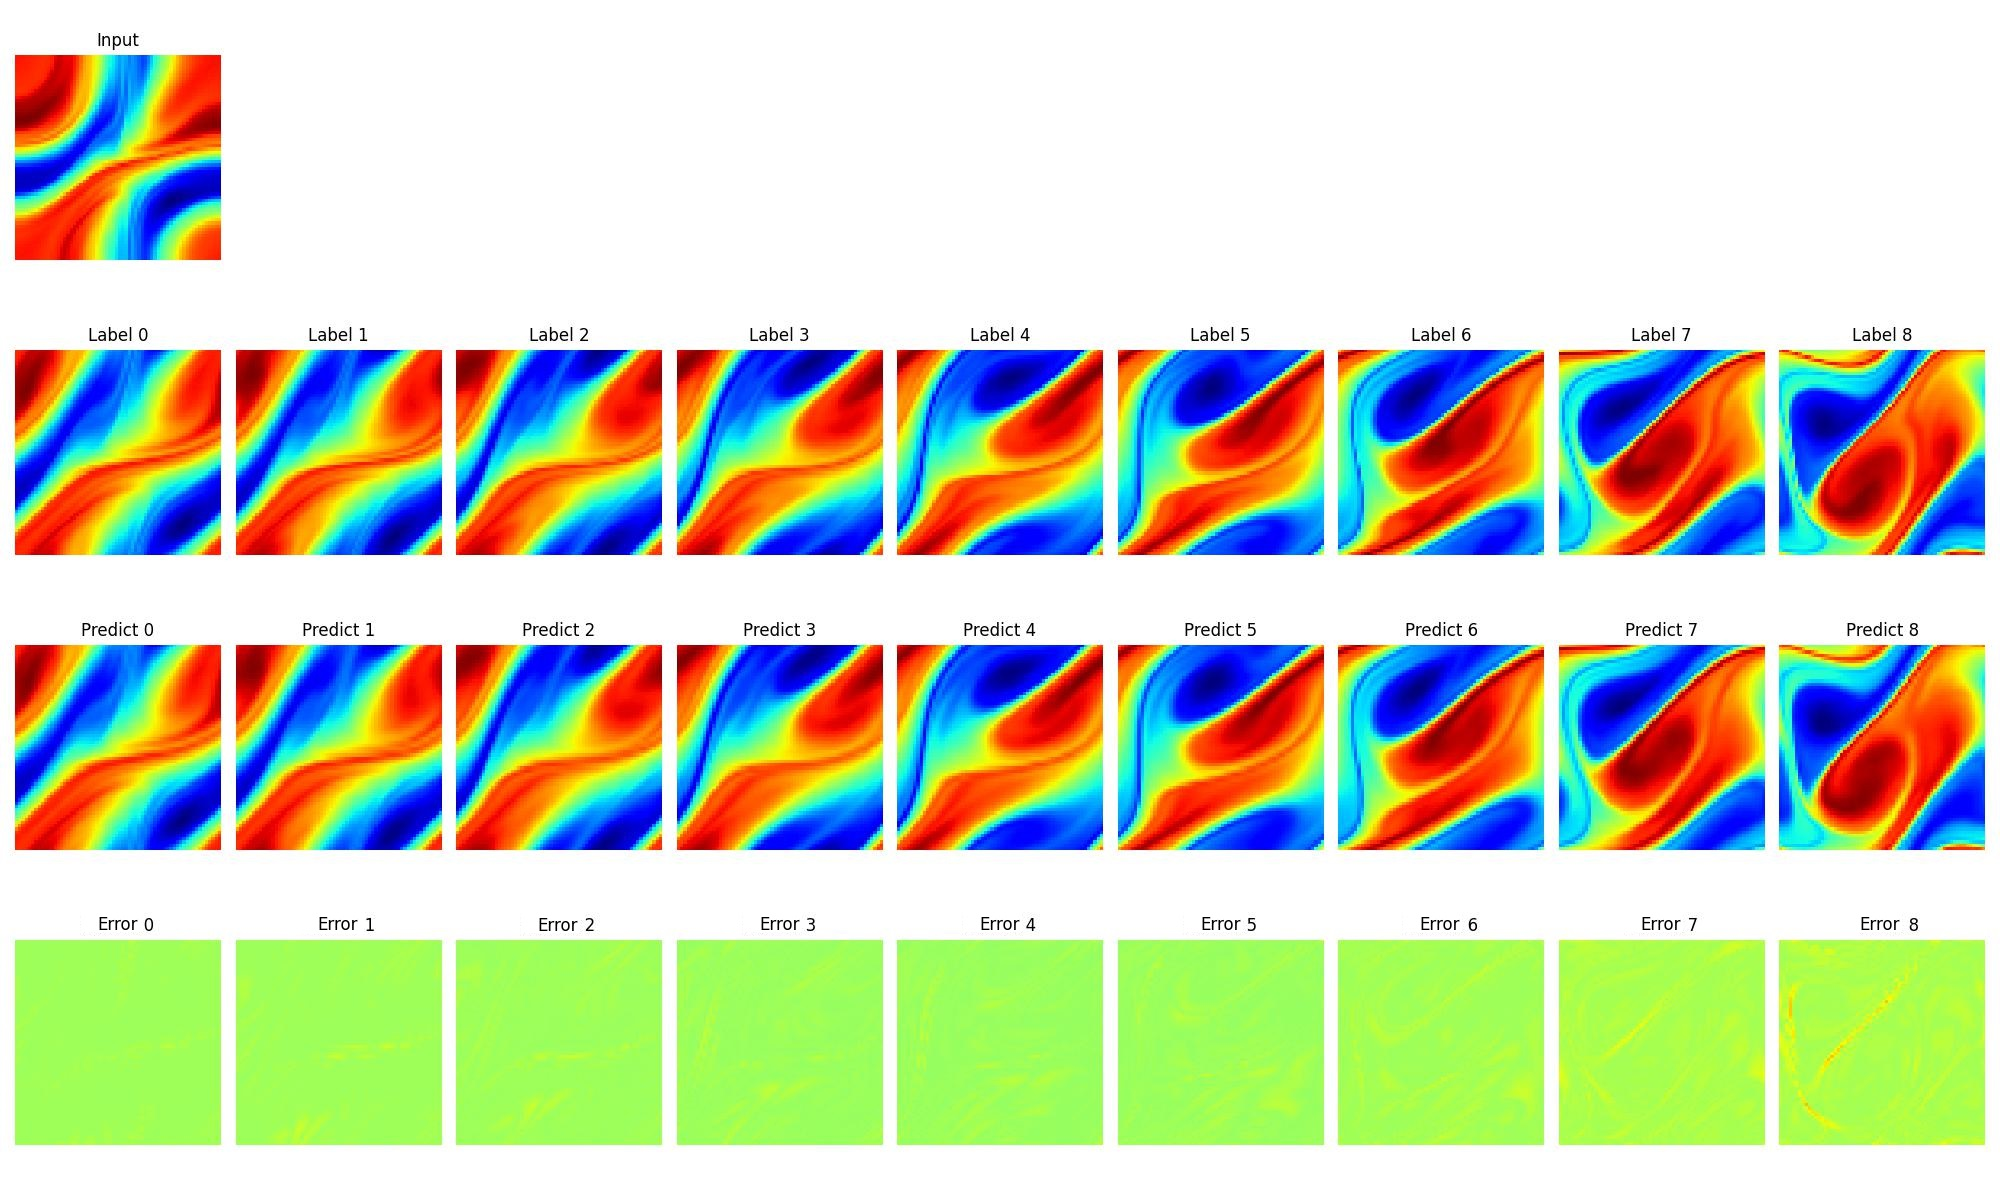

In [19]:
from IPython.display import Image, display
display(Image(filename='images/result.jpg', format='jpg', embed=True))

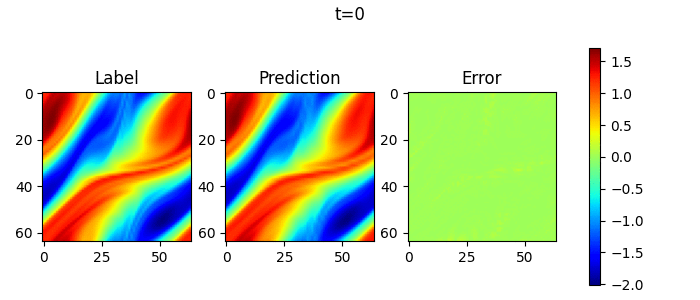

In [18]:
with open('images/result.gif', 'rb') as f:
    display(Image(data=f.read(), format='png', embed=True))